# Airbnb - Q2 & Q3 (Boston & Seattle) - Data Modeling & Evaluation

This notebook has been created to perform the modelling part of the process and to evaluate the model after. As such it will answer the second two bussiness questions as follows:

- Can I predict prices based on the market, variables & seasonal trend?
- Which AirBnB listing variables have the biggest impact on prices?

First I will attempt to create a machine learning model to predict what prices airbnb's should charge when adding a property and then during the evaluation process I will look at feature importance. These two steps should help answer the two business questions above.

## 1. Imports

In [1]:
# Imports basic functions
import pandas as pd
import numpy as np
import re

# Imports functions for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.style as style

# Sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Imports custom made airbnb package
import airbnb_pkg as airbnb

## 2. Functions

In [2]:
def plot_histogram(data, column, market, ax, binsize=50, y_label='', x_label='', color='blue'):
    """
    Function to plot standard histograms (Can be used for individual or side by side plots)
    """
    # Plots the Seattle Graph with title & axis
    sns.distplot(data[column], kde=False, color=color, bins=binsize, ax=ax)
    
    # Sets up the title based on the plotting column and the market    
    ax.set_title(f"{market} {column} data", fontsize=25)
    
    # Sets the y and x labels
    ax.set_ylabel(y_label, fontsize=20)
    ax.set_xlabel(x_label, fontsize=20)
    
    # Removes spines and changes layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def plot_line(data, ax, color, alpha=.7, ls='-', lw=5, label=None):
    """
    plots the standard line graph
    """
    ax.plot(data, color=color,
            alpha=alpha, ls=ls,
            linewidth=lw, label=label)
    
def outlier_removal(data, column, outlier_pctile=5):
    """
    Removes data from prices outside the 95 percentile
    """
    df = data.copy()
    upper_theshold = np.percentile(df[column].values, 100-outlier_pctile)
    lower_theshold = np.percentile(df[column].values, outlier_pctile)
    
    df = df[df[column] >= lower_theshold]
    df = df[df[column] <= upper_theshold]
    
    return df      
    
def validation_metrics(predictions, test, baseline_mae='', baseline_mape=''):
    # Obtain the absolute erros for each prediction
    errors = abs(predictions - test)

    print('Mean Absolute error:', round(np.mean(errors), 2))

    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(100 * (errors / test))

    print('Mean Absolute Percentage error:', round(np.mean(mape), 2))

    # Calculate and display accuracy
    accuracy = 100 - mape
    print('Accuracy:', round(accuracy, 2), '%.')
    
    if baseline_mae:
        # Compare to baseline
        improvement_baseline = mae - baseline_mae
        print('MAPE Improvement:', round(improvement_baseline, 2))    

    if baseline_mape:
        # Compare to baseline
        improvement_baseline = mape - baseline_mape
        print('MAPE Improvement:', round(improvement_baseline, 2), '%.')     

## 3. Basic Setup (Read data, create global variables etc.)

In [107]:
# Plotting settings
style.use('seaborn-poster') #sets the size of the charts
style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = "sans serif"

In [4]:
# Read in the .csv files for Seattle 
Seattle_Cal = pd.read_csv('Data/Seattle/calendar.csv')
Seattle_List = pd.read_csv('Data/Seattle/listings.csv')

# Read in the .csv files for Boston 
Boston_Cal = pd.read_csv('Data/Boston/calendar.csv')
Boston_List = pd.read_csv('Data/Boston/listings.csv')

In [5]:
# Create ML input using the function from the previous notebook
Seattle_input = airbnb.ML_preprocessing(Seattle_Cal, Seattle_List)
Boston_input = airbnb.ML_preprocessing(Boston_Cal, Boston_List)

/Users/warwick.rommelrath/Udacity/Airbnb_Data_Analysis/airbnb_pkg/__init__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for x in data['price']]
/Users/warwick.rommelrath/Udacity/Airbnb_Data_Analysis/airbnb_pkg/__init__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['date'] = pd.to_datetime(data['date'])


Columns dropped: {'square_feet'}
Number of rows dropped: 0
Columns dropped: {'square_feet'}
Number of rows dropped: 0


## 4. Modelling

To begin with I will run the modelling on the seattle data alone and then the Boston data will be ran to confirm the process:

I could apply PCA at this point but for the sake of looking into which variables are the most important I'm going to keep my data how it is (I will try PCA later on in this notebook after my initial analysis. 

For the ML I've decided to test the random forests algorthim for a few reasons:
- It's suited towards creating regression models with many features.
- It will be quick to train and get results which will be useful for a few reasons e.g. re-training on new markets, easily deployed in the workplace, keeps computational costs down.
- It's useful to look at feature importance.

The downsides potentially are:
- Although its much less prone than decision trees it can overfit occationally
- Some of the feature importance outputs may be skewed towards the catagorical variables in the data

In [6]:
# Set the X & Y variables
X = Seattle_input.iloc[:,1:]
Y = Seattle_input.iloc[:,0].values

# split into training & testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
Seattle_input.columns[0:]

Index(['Cal_price', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       ...
       'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed',
       'Suitable for Events', 'TV', 'Washer', 'Washer / Dryer',
       'Wheelchair Accessible', 'Wireless Internet'],
      dtype='object', length=106)

In [8]:
# setup the random forests classifier
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)

# specify parameters for grid search
parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}

# create grid search object
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)

# train classifier
reg.fit(X_train, y_train)

# predict on test data
y_pred = reg.best_estimator_.predict(X_test)

print("\nOptimised Model\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.3min finished



Optimised Model
------
RMSE Train Score: 0.8499270825947141
RMSE Test Score: 0.6668910533086816


The training accuracy score above is around RMSE  error is 85% accurate which is pretty good but the testing score of 67% is pretty bad showing that the model is acctually overfitting. One possible cause of this could be due to the amount of features we are trying to base the modelling on as we have 100+ all trying to influence it.

It's also worth pointing out that calculating the RMSE has the benefit of penalizing large errors but in this case it's possible that using MAE is a better function as it might be fine that some of the data points (the outliers) are way off from our prediction. Given this is might be worth removing these and re-testing. 

In [9]:
# Calculate accuracy based on MAE instead of RMSE

# Obtain the absolute erros for each prediction
errors = abs(y_pred - y_test)

print('Average absolute error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAE)
mae = np.mean(errors)

print('Mean Absolute error:', round(np.mean(mae), 2))

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))

print('Mean Absolute Percentage error:', round(np.mean(mape), 2))

# Calculate and display accuracy
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Save the model above as a baseline to check improvement
mae_baseline = mae
mape_baseline = mape

Average absolute error: 35.63
Mean Absolute error: 35.63
Mean Absolute Percentage error: 27.45
Accuracy: 72.55 %.


As we can see from calculating the MAE the absolute error is around 35.6 with a percentage error of 27.45% which again isn't perfect but isn't as skewed by outliers as by the RMSE. I will now remove the extreme outliers and re-create the model.

In [10]:
# Remove only the most extreme outliers
Seattle_ro = outlier_removal(Seattle_input, 'Cal_price', outlier_pctile=5)

# Set the X & Y variables
X = Seattle_ro.iloc[:,1:]
Y = Seattle_ro.iloc[:,0].values

# split into training & testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# setup the random forests classifier
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)

# specify parameters for grid search
parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}

# create grid search object
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)

# train classifier
reg.fit(X_train, y_train)

# predict on test data
y_pred = reg.best_estimator_.predict(X_test)

print("\nOptimised Model\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')

validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.6min finished



Optimised Model
------
RMSE Train Score: 0.9230109629615308
RMSE Test Score: 0.6133576669981613
Mean Absolute error: 26.67
Mean Absolute Percentage error: 23.86
Accuracy: 76.14 %.
MAPE Improvement: 0.0
MAPE Improvement: -3.59 %.


Removing the outliers increased the accuracy and the model is now probably being as skewed by the outlier datapoints. The next step will be to perform fetaure scaling, this will ensure that variables with a bigger varience don't have a bigger influence on the data.

In [11]:
# Perform feature scaling on the input data
StdSclr = StandardScaler()
Seattle_sc = pd.DataFrame(StdSclr.fit_transform(Seattle_ro))

# Set the X & Y variables
X = Seattle_sc.iloc[:,1:]
Y = Seattle_ro.iloc[:,0].values

# split into training & testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# setup the random forests classifier
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)

# specify parameters for grid search
parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}

# create grid search object
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)

# train classifier
reg.fit(X_train, y_train)

# predict on test data
y_pred = reg.best_estimator_.predict(X_test)

print("\nOptimised Model\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')

validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.6min finished



Optimised Model
------
RMSE Train Score: 0.8605475995754837
RMSE Test Score: 0.5682411216176564
Mean Absolute error: 28.07
Mean Absolute Percentage error: 23.52
Accuracy: 76.48 %.
MAPE Improvement: 0.0
MAPE Improvement: -3.93 %.


Fetaure scaling improved the MAPE error but increased the RMSE. This shows that the modelling became better for general points but again became worse for any small deviations.


In order to improve the model further we should look to how each feature is contributing to the model. The best way to find which features are contributing most to the model would be to re-train the model while dropping one feature each at a time and then recomputing the model scores. This may be compuationally intestive compaired to some other methods but it will clearly show what features are driving the model and which ones are making it worse. First I will re-run the original model with the best parameters as shown below:

In [12]:
reg.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=14, verbose=0,
                      warm_start=False)

In [50]:
def RF_price_model(X_model_input, Y_model_input):
    """
    Creates the price regression Random Forests based on the desired input df
    (Expects dependent variable to be the first column)
    """
    # Set the X & Y variables
    X = X_model_input.iloc[:,1:]
    Y = Y_model_input.iloc[:,0].values

    # split into training & testing data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    # setup the random forests classifier
    rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=14, verbose=0,
                      warm_start=False)

    # train classifier
    rf.fit(X_train, y_train)

    # predict on test data
    y_pred = rf.predict(X_test)

    print("\nOptimised Model\n------")
    print(f'RMSE Train Score: {rf.score(X_train, y_train)}')
    print(f'RMSE Test Score: {rf.score(X_test,y_test)}')
    
    validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)
    
    return rf, X_train, y_train
    

best_model, X_train, y_train = RF_price_model(Seattle_sc, Seattle_ro)


Optimised Model
------
RMSE Train Score: 0.860505797551363
RMSE Test Score: 0.5836600514404544
Mean Absolute error: 26.71
Mean Absolute Percentage error: 23.62
Accuracy: 76.38 %.
MAPE Improvement: 0.0
MAPE Improvement: -3.82 %.


Now we have our best model I can run it through the feature importance function I've created that loops through each column and removes it from the input prior to creating the model. If we compaire this to the accuracy of the core model we will have an idea of which columns are having a positive or negative influence:

In [51]:
def feature_importance(model, X_train, y_train, input_data, rand_state):
    """
    This module calculates the feature importance of all columns
    """
    # Creates a list for storing the importance info
    feat_imp = []
    
    # clone the model
    mod_clone = clone(model)
    
    # set random_state, train and score the benchmark model
    mod_clone.random_state = rand_state
    mod_clone.fit(X_train, y_train)
    mod_score = mod_clone.score(X_train, y_train)
    
    # Loop through columns creating feature importance score    
    for col in X_train.columns:
        # Drop the column we are calulating the influence of         
        X_input = X_train.drop(columns=[col])
        
        # Repeat the process of cloning, random state, train and score         
        new_mod = clone(model)
        new_mod.random_state = rand_state
        new_mod.fit(X_input, y_train)
        update_score = new_mod.score(X_input, y_train)
        
        # Calulate the feature importance and append to list
        feat_imp.append(mod_score - update_score)
    
    # Create the output that shows each columns feature importance     
    importances_df = pd.DataFrame(feat_imp, index=input_data.columns)
    
    return importances_df

importance = feature_importance(best_model, X_train, y_train, Seattle_ro.iloc[:,1:], 14)

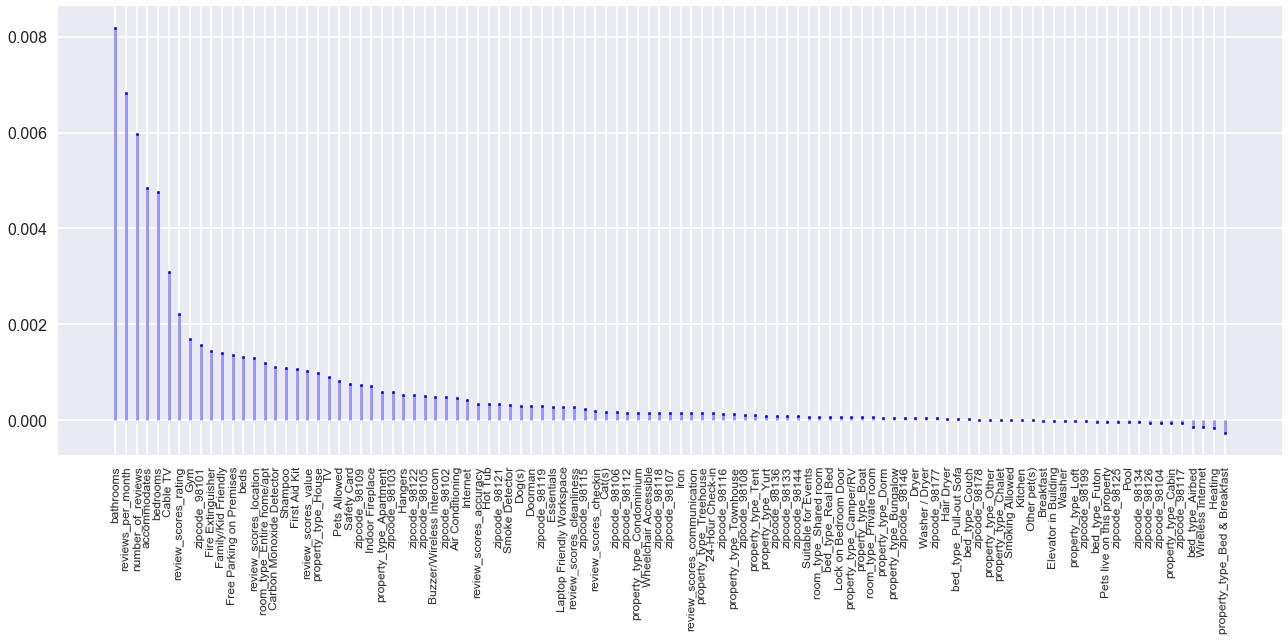

In [52]:
def plot_feature_importance(feat_importance):
    """
    This plot is designed to plot the feature performance in the model
    """
    # It's probably easier to represent this data graphically
    fig, ax = plt.subplots(figsize=(18,9))

    # Sorts the data
    sorted_imp = feat_importance.sort_values(0, ascending=False)
    
    # Select the X & Y values
    x = range(1,len(sorted_imp)+1)
    y = sorted_imp.values

    # Creates a vertical line graph
    import seaborn as sns
    ax.vlines(x=x, ymin=0, ymax=y, color='blue', alpha=0.4)
    ax.scatter(x, y, color='blue', s=6, alpha=1)

    # Format the X-axis
    plt.xticks(range(1,len(sorted_imp)+1), list(sorted_imp.index), rotation=89, fontsize=12)

    plt.tight_layout()
    
plot_feature_importance(importance)

Its odd that the highest performing variable is 'bathroom' this is probably due to large properties having extra bathrooms but some of the other high values do make more sense like 'accomodates' & 'bedrooms'. The results show that a few of the variables that I'm putting into the model are acctually having a negative effect on the outcome and might as well be ignored.

At this point it might be worth dropping some of the values that are having a negative influence on the model or at least the worst perfoming ones and running the analysis & potentially re-running the model to see if they both improve.

In [56]:
# Select the colums that are below zero
col_drop = list(importance[importance[0] < 0].index)

# Drop the unimportant columns
Seattle_drop = Seattle_ro.drop(columns=col_drop)

# Perform feature scaling on the input data
StdSclr = StandardScaler()
Seattle_sc_update = pd.DataFrame(StdSclr.fit_transform(Seattle_drop))

# Re-crea
new_rf, X_train, y_train = RF_price_model(Seattle_sc_update, Seattle_drop)


Optimised Model
------
RMSE Train Score: 0.8567396449312146
RMSE Test Score: 0.6045210510643724
Mean Absolute error: 25.94
Mean Absolute Percentage error: 23.26
Accuracy: 76.74 %.
MAPE Improvement: 0.0
MAPE Improvement: -4.19 %.


In [57]:
# Re-run the feature importance
importance_updated = feature_importance(new_rf, X_train, y_train, Seattle_drop.iloc[:,1:], 14)

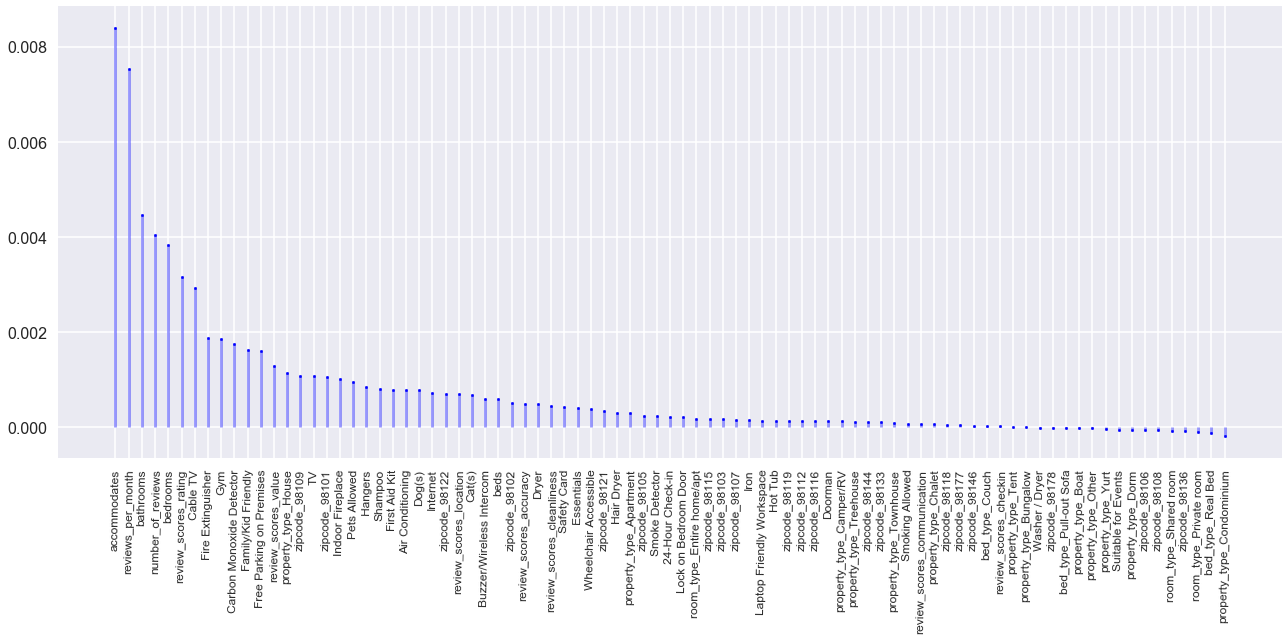

In [58]:
# Re-do the graph
plot_feature_importance(importance_updated)

The MAPE is still icreasing with the reduction of features which is great to see but the RMSE error decreased again slightly showing that removing these features has probably made the results worse for some extremes but better as a general model overall.

##### Answer: - Which AirBnB listing variables have the biggest impact on prices?

The results of the above feature importance show that the reviews per month, number it accomodates, number of reviews and number of bedrooms are the important features that can be used most to predict the price of an Airbnb. In terms of impact on price this suggests that the latent feature of number of people who can stay at an Airbnb has the biggest influence. This makes sense are the more people a property can hold is probably very related to how much they can charge. Features such as reviews per month and number of reviews would probably show how popular a property is and therefore if a user can charge more. While these are useful for current users (maybe Airbnb could tell users with a certain amount of reviews that they could increase their listing by X amount) they are not very useful for predicting price and so to answer my second question it would be worth removing these for the final model:

In [59]:
# Drop columns related to no of reveiws as they are not useful for users with the cold start problem
# Select the colums that are below zero
col_drop = list(importance[importance[0] < 0].index) + ['reviews_per_month','number_of_reviews','review_scores_rating']

# Drop the unimportant columns
Seattle_drop = Seattle_ro.drop(columns=col_drop)

# Perform feature scaling on the input data
StdSclr = StandardScaler()
Seattle_sc_update = pd.DataFrame(StdSclr.fit_transform(Seattle_drop))

# Re-crea
new_rf, X_train, y_train = RF_price_model(Seattle_sc_update, Seattle_drop)


Optimised Model
------
RMSE Train Score: 0.8298957493256547
RMSE Test Score: 0.5864460027690714
Mean Absolute error: 27.73
Mean Absolute Percentage error: 24.29
Accuracy: 75.71 %.
MAPE Improvement: 0.0
MAPE Improvement: -3.15 %.


In [60]:
# Re-run the feature importance
importance_updated = feature_importance(new_rf, X_train, y_train, Seattle_drop.iloc[:,1:], 14)

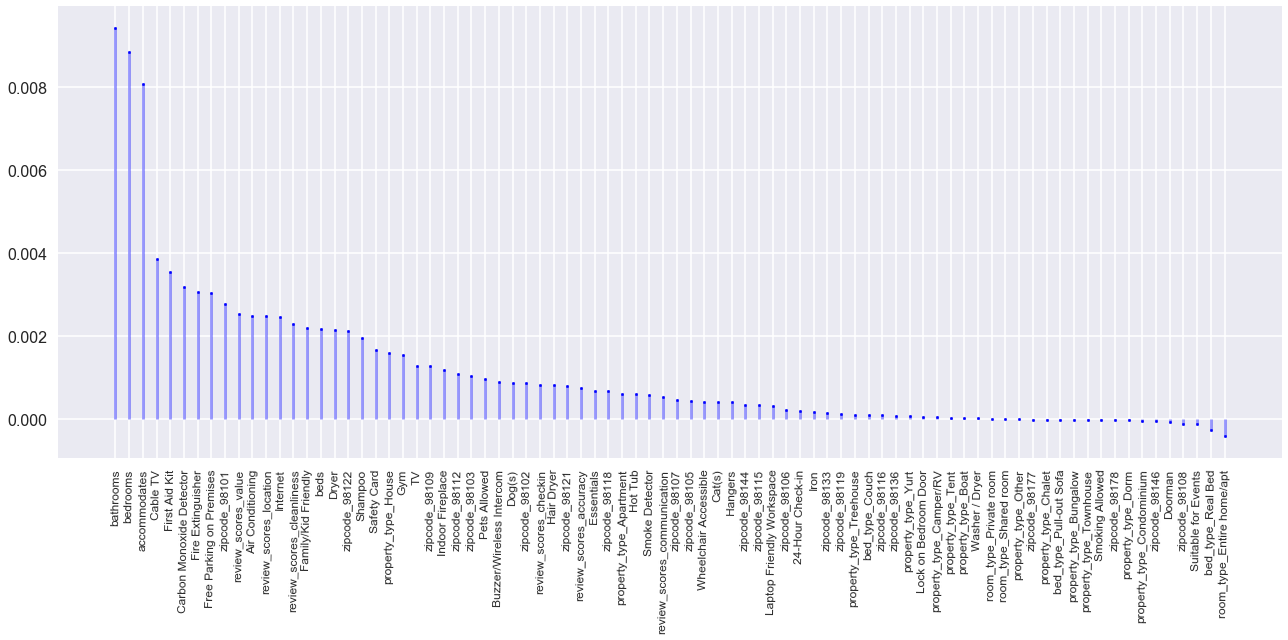

In [61]:
# Re-do the graph
plot_feature_importance(importance_updated)

##### Answer: - Can I predict prices based on the market, variables & seasonal trend?

Removing the features that cannot be used without prior knowledge shows that the bathrooms, bedrooms and accomodates are the top performing features. This shows that with just the knowlegde of just the property type and features we can get a good estmate of prices with a 75% accuracy. This is probably good enough to reccomend it to Airbnb users as it's more of a guideline and they can go higher or lower than the value if they need to. Below I will run some confirmation visualisations and perform the same process on the Boston data to see if I get similar results.

In [64]:
# Remove only the most extreme outliers
Boston_ro = outlier_removal(Boston_input, 'Cal_price', outlier_pctile=5)

# Drop columns related to no of reveiws as they are not useful for users with the cold start problem
# Select the colums that are below zero
col_drop = ['reviews_per_month','number_of_reviews','review_scores_rating']

# Drop the unimportant columns
Boston_drop = Boston_ro.drop(columns=col_drop)

# Perform feature scaling on the input data
StdSclr = StandardScaler()
Boston_sc_update = pd.DataFrame(StdSclr.fit_transform(Boston_drop))

# Create the boston model
Boston_rf, Boston_X_train, Boston_y_train = RF_price_model(Boston_sc_update, Boston_drop)


Optimised Model
------
RMSE Train Score: 0.899395665137626
RMSE Test Score: 0.7148174200817463
Mean Absolute error: 35.79
Mean Absolute Percentage error: 23.2
Accuracy: 76.8 %.
MAPE Improvement: 0.0
MAPE Improvement: -4.24 %.


In [66]:
# Re-run the feature importance
importance_updated = feature_importance(Boston_rf, Boston_X_train, Boston_y_train, Boston_drop.iloc[:,1:], 14)

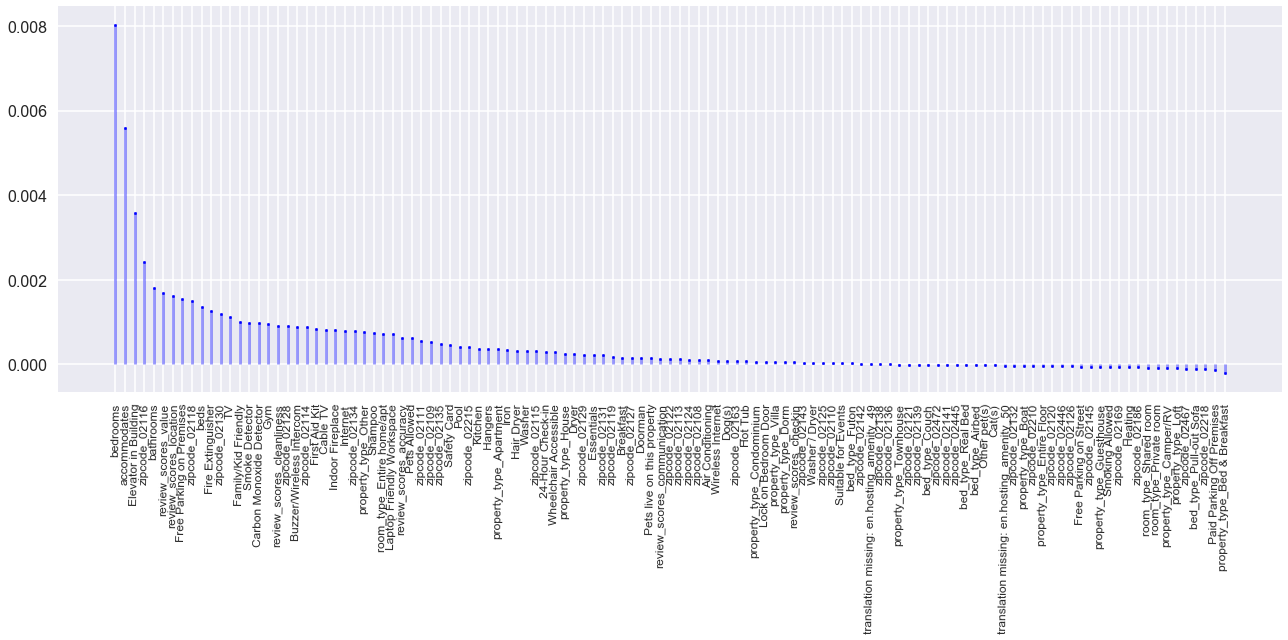

In [67]:
# Re-do the graph
plot_feature_importance(importance_updated)

The results of the Boston data show that the model works just as well on another dataset. The below plots shown exactly how the data points vary from the predictions and validates that both models work fairly well.

In [168]:
def Airbnb_model(model_input, market, plot=True, color='blue'):
    """
    Creates the price regression Random Forests based on the desired input df
    (Expects dependent variable to be the first column)
    """
    # Remove only the most extreme outliers
    data_input = outlier_removal(model_input, 'Cal_price', outlier_pctile=5)  
    
    # Sorts ready for the plot
    data_input = data_input.sort_values('Cal_price')
        
    # Select the colums that are below zero
    col_drop = ['reviews_per_month','number_of_reviews','review_scores_rating']

    # Drop the unimportant columns
    data_drop = data_input.drop(columns=col_drop)

    # Perform feature scaling on the input data
    StdSclr = StandardScaler()
    data_scalar = pd.DataFrame(StdSclr.fit_transform(data_drop))
    
    # Set the X & Y variables
    X = data_scalar.iloc[:,1:]
    Y = data_drop.iloc[:,0].values

    # split into training & testing data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    # setup the random forests classifier
    rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=14, verbose=0,
                      warm_start=False)

    # train classifier
    rf.fit(X_train, y_train)

    # predict on test data
    y_pred = rf.predict(X_test)

    # create plot
    fig, ax = plt.subplots(figsize=(12,12))
    
    # Sets up the title based on the plotting column and the market    
    ax.set_title(f"{market} - Prediction of Airbnb prices", fontsize=18)

    # plot line
    plt.scatter(y_pred, y_test, s=50, color=color, alpha=.5)
    plt.plot(y_test, y_test, label='Perfect Prediction', color='black', linewidth=3, alpha=.4)
    
    # adds x and y labels
    ax.set_ylabel('Predicted Airbnb Prices', fontsize=18)
    ax.set_xlabel('Actual Airbnb Prices', fontsize=18)
    
    # plot legend
    ax.legend(fontsize=10)

    # show/close
    plt.show() 

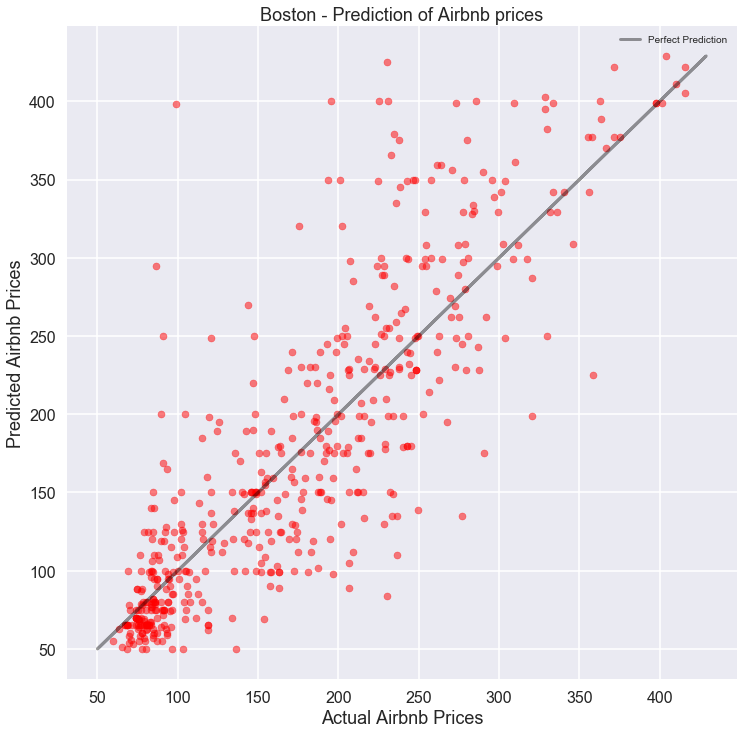

In [171]:
Airbnb_model(Boston_input, 'Boston', plot=True, color='red')

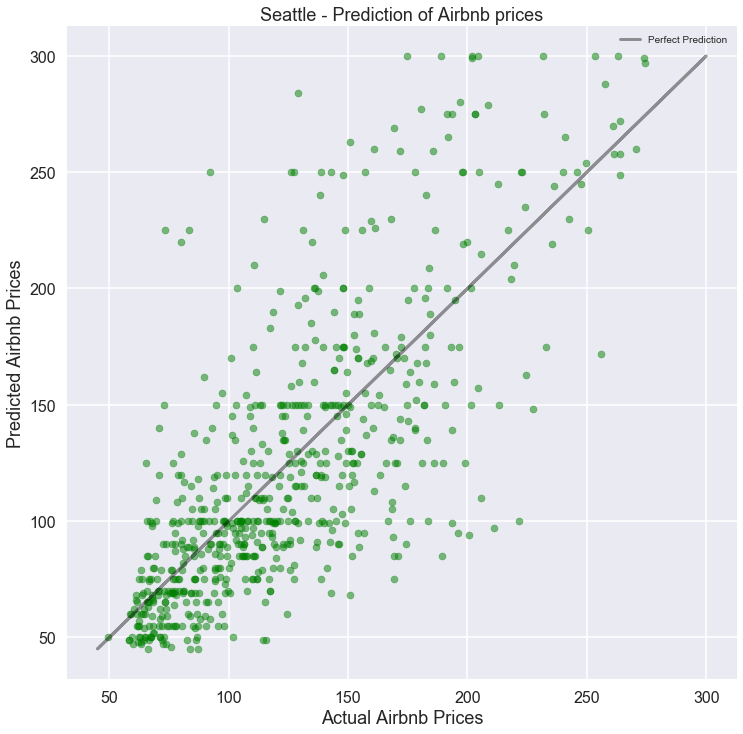

In [172]:
Airbnb_model(Seattle_input, 'Seattle', plot=True, color='green')